In [ ]:
#code: utf-8
from google.colab import drive
import sys
import os
import numpy as np
#import pandas as pd
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#import albumentations as albu

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score

#from tqdm import tqdm
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as pat
#import seaborn as sns

In [ ]:
drive.mount('/content/gdrive')
ROOT_PATH = '/content/gdrive/My Drive/Colab Notebooks'
CUR_PATH = '/content/gdrive/My Drive/Colab Notebooks/Othello_AI'
if ROOT_PATH not in sys.path:
  sys.path.append(ROOT_PATH)
if CUR_PATH not in sys.path:
  sys.path.append(CUR_PATH)

#for load params of trained model
SL_MODEL_NAME = "conv4_bn_mini"
SL_No = 40
SL_PARAM_NAME = f"SLpn_{SL_MODEL_NAME}_{SL_No}"
SL_PARAM_PATH = os.path.join(CUR_PATH, "SLpn_params", f"{SL_PARAM_NAME}.pth")

#for save params of policy model
MODEL_NAME = "dqn_conv4"
No = 72
PARAM_NAME = f"RLpn_{MODEL_NAME}_{No}"
PARAM_PATH = os.path.join(CUR_PATH, "RLpn_params", f"{PARAM_NAME}.pth")
BEST_PARAM_PATH = os.path.join(CUR_PATH, "RLpn_params", f"{PARAM_NAME}_best.pth")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


RL model:

- 1: vs SL model, select_action=determinism, lr=2e-5

- 2: select_action=probability theory, lr=1e-6?

- 21: vs random action, select_action=determine, lr=5e-6, EPOCH=5000

- 22: select_action=determine

- 23: reward=my stones: (win, draw, lose)=(1.0 to 0.5, 0.0, -0.5 to -1.0), win,lr=8e-6, EPOCH=5000

- 24: select_action_random=probability in capable place, lr=2e-5, EPOCH=200

- 41: SLmodel=trained nodup-nowrong-trained data, EPOCH=1024, episode=2*2, target update=2 lr=4e-06

- 51: reward: (win, draw, lose)=(1., 0., -1.), lr=8e-06

- 61: 1 data got in a battle, EPOCH=1024, episode=2*32, target update=1, PARAM_STOCK=16, EPS_START=0.16=5/32, EPS_END=0.03=1/32

- 63: EPOCH=256, add LogSoftmax at before loss func in optimizer func, alpha=1

- 70: max vs max

- 71: to memory only random action, EPS_START=1/32

In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
SEED = 2021
set_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import gym
import tools
env = gym.make("othello-v0")

#defining hyper parameters

In [ ]:
#LR = 0.000001
GAMMA = 0.99
buffer_limit = 5000
BATCH_SIZE = 64
POSTMAX = 25
dummy_data = 64

#making replay memory

In [ ]:
#transition = (states, actions, nexts, players)

class ReplayMemory(object):
    def __init__(self, capacity=64):
        self.capacity = capacity
        self.reset()


    def reset(self):
        self.idx = 0
        self.transition = [[], [], [], []] #states, actions, nexts, players
    

    def push(self, args):
        for i in range(len(args)):
            self.transition[i].append(None)
            self.transition[i][self.idx] = args[i]
        self.idx = (self.idx + 1) % self.capacity


    def __getitem__(self, idx):
        return [ts[idx] for ts in self.transition]


    def sample(self, batch_size):
        idxs = [i for i in range(self.idx)]
        batch_size = min(batch_size, self.idx)
        idxs = random.sample(idxs, batch_size)
        samples = []
        for id in range(batch_size):
            samples.append([ts[id] for ts in self.transition])
        return samples #[trainsiton[a], transition[b],,,] to use as iter
    

    def __len__(self):
        return self.idx


    def __call__(self):
        return self.transition

#defining model

In [ ]:
class Conv4_bn_mini(nn.Module):
  def __init__(self):
    super(Conv4_bn_mini, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.act1 = nn.ReLU()
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.act2 = nn.ReLU()
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.act3 = nn.ReLU()
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.act4 = nn.ReLU()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(64*8*8, 64)

  def forward(self, x):
    x = self.act1(self.bn1(self.conv1(x)))
    x = self.act2(self.bn2(self.conv2(x)))
    x = self.act3(self.bn3(self.conv3(x)))
    x = self.act4(self.bn4(self.conv4(x)))
    x = self.flatten(x)
    x = self.fc1(x)
    return x

#making transform

In [ ]:
class Transform(object):
    def __init__(self, state, action, nexte):
        self.state = state.reshape((-1, 8, 8)).astype("float32")
        self.nexte = nexte.reshape((-1, 8, 8)).astype("float32")
        self.action = action
        self.randk = random.randint(0, 3)

    #for transform action
    def _act_rotate90(self, x, y, k):
        for _ in range(k):
            x, y = y, -1*x + 7
        return x, y

    #for tansform action
    def _act_flip(self, x, y):
        x, y = x, -1*y + 7
        return x, y


    def rotate(self, mode="train"):
        x, y = self.action%8, self.action//8

        if mode == "train":
            p = self.randk % 2
            if p > 0:
                self.state = np.flip(self.state, axis=1).copy()
                self.nexte = np.flip(self.nexte, axis=1).copy()
                x, y = self._act_flip(x, y)
            self.state = np.rot90(self.state, self.randk, axes=(1, 2)).copy()
            self.nexte = np.rot90(self.nexte, self.randk, axes=(1, 2)).copy()
            x, y = self._act_rotate90(x, y, self.randk)

        elif mode == "valid":
            pass

        elif mode == "debug":
            k = 3 #0-3 existable pattern
            p = k % 2
            if p > 0:
                self.state = np.flip(self.state, axis=1).copy()
                self.nexte = np.flip(self.nexte, axis=1).copy()
                x, y = self._act_flip(x, y)
            self.state = np.rot90(self.state, k, axes=(1, 2)).copy()
            self.nexte = np.rot90(self.nexte, k, axes=(1, 2)).copy()
            x, y = self._act_rotate90(x, y, k)

        else:
            pass
            
        action = x + y*8
        return self.state, action, self.nexte

In [ ]:
def to_feature(state, player):
    state = state.reshape((-1, 8, 8)).astype("float32")
    opp_stone = np.where(state == 3 - player, 1, 0)
    my_stone = np.where(state == player, 1, 0)
    all_stone = np.where(state > 0, 1, 0)
    state = np.stack([all_stone, opp_stone, my_stone], axis = 1).reshape(3, 8, 8) #axis check
    state = torch.tensor(state).float()
    return state

#making dataset

In [ ]:
#board => 3 dim state
#player = 1: white, 2: black
class DQNDatasets(Dataset):
    def __init__(self, transition, rewards):
        self.name = {}
        for num, key in enumerate(("states", "actions", "nexts", "players")):
            self.name[key] = num
        self.transition = transition
        self.rewards =rewards

    def __len__(self):
        return len(self.transition[self.name["players"]])
    
    def __getitem__(self, idx):
        state = self.transition[self.name["states"]][idx]
        action = self.transition[self.name["actions"]][idx]
        next_state = self.transition[self.name["nexts"]][idx]
        player = self.transition[self.name["players"]][idx]
        reward = self.rewards[idx]
        state, action, next_state = Transform(state, action, next_state).rotate(mode="train")

        state = to_feature(state, player)
        next_state = to_feature(next_state, player)
        action = [action]

        #state = torch.tensor(state).float()
        action = torch.tensor(action).long()
        #next_state = torch.tensor(next_state).float()
        reward = torch.tensor(reward).float()
        return state, action, next_state, reward

#making select action

In [ ]:
EPS_START = 0.03 #max
EPS_END = 0.01 #min
EPS_DECAY = 500 #decay to decrease

class PolicyNet(object):
    def __init__(self, model):
        self.model = model


    def get_pred(self, state, player, posts):
        state = to_feature(state, player)
        state = state.reshape(-1, 3, 8, 8)
        state = state.to(device)
        self.model.eval()
        with torch.no_grad():
            pred = self.model(state)
            return pred.to('cpu').detach().numpy().reshape(64)


    def get_action_egreedy(self, state, player, posts, epoch, mode="max"):
        p = random.random()
        eps_thr = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * epoch / EPS_DECAY)
        if p > eps_thr:

            state = to_feature(state, player)
            state = state.reshape(-1, 3, 8, 8)
            state = state.to(device)
            self.model.eval()
            with torch.no_grad():
                pred = self.model(state)
                if len(posts) > 0: #exist to place
                    pred = torch.gather(pred, 1, torch.tensor([posts], device=device, dtype=torch.long))
                    pred = nn.Softmax(dim=1)(pred)
                    if mode == "prob": #prob in capable to place
                        idx = torch.multinomial(pred, 1).item()
                    elif mode == "max": #max pred
                        idx = pred.max(1)[1]
                    else:
                        idx = pred.max(1)[1]
                    return torch.tensor([posts[idx]], device=device, dtype=torch.long)
                else: #skip turn
                    return pred.max(1)[1].reshape(-1, 1)

        else:
            return torch.tensor([-1], device = device, dtype = torch.long) #random in capable to place only


    def get_action(self, state, player, posts, mode="max"):
        state = to_feature(state, player)
        state = state.reshape(-1, 3, 8, 8)
        state = state.to(device)
        self.model.eval()
        with torch.no_grad():
            pred = self.model(state)
            if len(posts) > 0: #exist to place
                pred = torch.gather(pred, 1, torch.tensor([posts], device=device, dtype=torch.long))
                pred = nn.Softmax(dim=1)(pred)
                if mode == "prob": #prob in capable to place
                    idx = torch.multinomial(pred, 1).item()
                elif mode == "max": #max pred
                    idx = pred.max(1)[1]
                else:
                    idx = pred.max(1)[1]
                return torch.tensor([posts[idx]], device=device, dtype=torch.long)
            else: #skip turn
                return pred.max(1)[1].reshape(-1, 1)


    def update_params(self, params):
        self.model.load_state_dict(params)

#making optimize 

In [ ]:
GAMMA = 0.99

class Trainer(object):
    def __init__(self, policy_model, target_model, optimizer):
        self.policy_model = policy_model
        self.target_model = target_model


    def fit(self, memory, reward, batch_size=64):
        tdloss = 0
    
        dqn_dataset = DQNDatasets(memory, reward)
        dqn_loader = DataLoader(dqn_dataset, batch_size=batch_size, shuffle=True)

        for state, action, next_state, reward in dqn_loader:
            state = state.to(device)
            action = action.to(device)
            next_state = next_state.to(device)
            reward = reward.to(device)
            
            #Q(s_t, a)
            #calculate Q(s_t) get a = actions
            #all actions lead policy_net
            self.policy_model.train()
            pred = self.policy_model(state)
            pred = nn.LogSoftmax(dim=1)(pred)
            state_action_values = pred.gather(1, action)
            
            #calcurate V(s_{t+1}) about all next states.
            #Expected value at next state on non_final_next_ by target net before update.
            #this values are 0 at final and expected values on next at others.
            next_state_values = torch.zeros(state.shape[0], device=device)
            self.target_model.eval()
            next_state_pred = self.target_model(next_state)
            next_state_pred = nn.LogSoftmax(dim=1)(next_state_pred)
            next_state_values = next_state_pred.max(1)[0].detach() #in all positions

            #calculate expected Q value
            #more expected_sa_value: next_state = next_my_state = after 2 steps
            expected_state_action_values = GAMMA * next_state_values + reward

            #calculate Huber loss
            #print(state_action_values[0].item(), expected_state_action_values.unsqueeze(1)[0].item())
            loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

            #update model param
            optimizer.zero_grad()
            loss.backward()
            for param in self.policy_model.parameters():
                param.grad.data.clamp_(-1, 1)
            optimizer.step()
            tdloss += loss.item() / len(dqn_loader)
        return tdloss


    def target_update(self):
        self.target_model.load_state_dict(self.policy_model.state_dict())

#get reward function

In [ ]:
def get_reward(play, last_player, reward, state, mode="raw"):
    if mode == "raw": # reward= {lose: -1, draw: 0, win: 1}
        if play == last_player:
            return reward, reward
        else:
            return -1*reward, -1*reward
    else:
        opp_stones = np.sum(np.where(state == 3 - play, 1, 0))
        my_stones = np.sum(np.where(state == play, 1, 0))
        all_stones = np.sum(np.where(state > 0, 1, 0))
        if  mode == "winstone_rate": #reward= {lose: -1.0<= <-0.5, draw: 0, win:0.5< <=1.0}
            if play == last_player:
                return reward, my_stones / all_stones
            else:
                return -1*reward, -1*opp_stones / all_stones
        elif mode == "sub_rate": #reward= {lose: -1.0<= <0, draw: 0, win:0.< <=1.0}
            if play == last_player:
                reward = reward
            else:
                reward = -1*reward
            return reward, (my_stones - opp_stones) / all_stones
        else:
            if play == last_player:
                return reward, reward
            else:
                return -1*reward, -1*reward

#show heatmap

In [ ]:
white, black = 1, 2
color = ("white", "black")

def policy_heatmap(state, pred, posts, player): 
    fig, ax= plt.subplots(1, 1, figsize=(6, 6))
    pred_num = np.argsort(-pred)
    pred_num = pred_num.tolist()
    pred = pred.reshape(8, 8)
    plt.imshow(pred, interpolation='nearest', cmap='magma')
    plt.colorbar()

    for y in range(8):
        for x in range(8):
            st = state[y][x]

            if x + 8*y in posts: #capable to place
                r = pat.Rectangle(xy=(x-0.38, y-0.38), width=0.8, height=0.8, linewidth=2, ec='g', fill=False)
                ax.add_artist(r)

            if st > 0: #draw circle
                if st == 1:
                    fc, ec = 'w', 'k' #face=white, edge=black
                elif st == 2:
                    fc, ec = 'k', 'w'
                c = pat.Circle(xy=(x, y), radius=0.4, fc=fc, ec=ec, fill = True)
                ax.add_artist(c)
            #print (arg pred)
            rank = pred_num.index(x+8*y) + 1
            ax.text(x-0.25, y+0.25, f"({rank:2d})", size=8, color='green', fontweight='bold')
            ax.text(x-0.3, y-0.1, f"{x+y*8:2d}", size=9, color='red', fontweight='bold')

    ax.set_title(f"player: {color[player-1]}")
    plt.show()

#othello class

In [ ]:
class OthelloPlay(object):
    def __init__(self, Mymodel, Oppmodel):
        self.model = (Mymodel, Oppmodel)
        self.env = gym.make("othello-v0")
        self.env.reset()
        self.memory = ReplayMemory(128)
        self.battle_memory = ReplayMemory(64)


    def play_with_memory(self, memory, play, epoch):
        self.env.reset()
        memory.reset()
        cnt = 0
        pre_state = np.array([[-1]*8 for _ in range(8)])
        while not self.env.done:
            cnt += 1
            state = self.env.render("rgb_array")
            _posts, _, _ = self.env.next_place
            player = self.env.player #black
            posts = _posts[:]
            if player == play: #play: my model
                #push into memory
                if pre_state[0][0] != -1:
                    if pred_action.item() == -1 and action >= 0:
                        memory.push((pre_state.copy(), action, state.copy(), player))
                    #print(pre_state.copy(), [action], state.copy(), player)
                #step on action
                pred_action = self.model[0].get_action_egreedy(state.copy(), player, posts, epoch, mode="max")
                state, action, next_state, reward, done, player = self.env.step(pred_action.item())
                pre_state = state.copy()
            else: #play: opp model
                op_pred_action = self.model[1].get_action(state.copy(), player, posts, mode="max")
                #step on action
                state, op_action, next_state, reward, done, player = self.env.step(op_pred_action.item())   
        #save last state
        state = next_state.copy()
        if pred_action.item() == -1 and action >= 0 and player == play:
            memory.push((pre_state.copy(), action, state.copy(), play))
        #get reward
        reward, rl_reward = get_reward(play, player, reward, state.copy(), mode="sub_rate")
        return reward, rl_reward, cnt


    def play(self, play):
        self.env.reset()
        cnt = 0
        while not self.env.done:
            cnt += 1
            state = self.env.render("rgb_array")
            posts, _, _ = self.env.next_place
            player = self.env.player
            #step on action
            if player == play: #Mymodel
                pred_action = self.model[0].get_action(state.copy(), player, posts, mode="max")
            else: #Oppmodel
                pred_action = self.model[1].get_action(state.copy(), player, posts, mode="max")
            state, action, next_state, reward, done, player = self.env.step(pred_action.item())
        #get reward
        if play == player:
            reward = reward
        else:
            reward = -1*reward
        return reward, cnt


    def play_with_show(self, play):
        self.env.reset()
        cnt = 0
        while not self.env.done:
            cnt += 1
            state = self.env.render("rgb_array")
            posts, _, _ = self.env.next_place
            player = self.env.player
            #get pred
            pred = self.model[player-1].get_pred(state.copy(), player, posts)
            #show board
            policy_heatmap(state.copy(), pred, posts, player)
            #step on action
            if player == play: #Mymodel
                pred_action = self.model[0].get_action(state.copy(), player, posts, mode="max")
            else: #Oppmodel
                pred_action = self.model[1].get_action(state.copy(), player, posts, mode="max")
            state, action, next_state, reward, done, player = self.env.step(pred_action.item())
            print(f"action: {action}")
        #get reward
        if play == player:
            reward = reward
        else:
            reward = -1*reward
        return reward, cnt

    
    def train_battle(self, episode, epoch, choose_size=1):
        self.memory.reset()
        rewards = []
        bt_cnt = [[0, 0, 0], [0, 0, 0]] #[white:[lose, draw, win], black:[]]
        step_cnt = 0
        for epi in tqdm(range(episode)):
            for play in (1, 2):
                self.battle_memory.reset()
                reward, rl_reward, cnt = self.play_with_memory(self.battle_memory, play, epoch)
                if len(self.battle_memory) > 0:
                    for sample in self.battle_memory.sample(choose_size):
                        self.memory.push(sample)
                    rewards.append(rl_reward)
                bt_cnt[play-1][int(1+reward)] += 1
                step_cnt += cnt
        return self.memory(), rewards, bt_cnt, step_cnt


    def test_battle(self, battles):
        bt_cnt = [[0, 0, 0], [0, 0, 0]] #[white:[lose, draw, win], black:[]]
        step_cnt = 0
        for _ in range(battles):
            for play in (1, 2):
                reward, cnt = self.play(play)
                bt_cnt[play-1][int(1+reward)] += 1
                step_cnt += cnt
        return bt_cnt, step_cnt

#main loop

In [ ]:
EPOCH = 256 #256
EPS_DECAY = EPOCH // 3
num_episodes = 64
BATCH_SIZE = min(128, num_episodes*2)
memory_batch_size = 1
TARGET_UPDATE = 1
PARAM_STOCK = 8
TEST_FREC = 8
test_battles = 10
OP_CHANGE = 8
model_n = 0
LR = 0.00002#0.000008
episode_durations = []
loss_data = []
winrate_data = []
acc_data = []
vs_data = []
print(f"train model: {MODEL_NAME}_{No} Epoch: {EPOCH} episode: 2*{num_episodes} target update: {TARGET_UPDATE} learning rate: {LR}")

train model: dqn_conv4_72 Epoch: 256 episode: 2*64 target update: 1 learning rate: 2e-05


In [ ]:
policy_model = Conv4_bn_mini().to(device)
policy_model.load_state_dict(torch.load(SL_PARAM_PATH, map_location = device))
policy_model.train()
target_model = Conv4_bn_mini().to(device)
target_model.load_state_dict(policy_model.state_dict())
target_model.eval()
opponent_model = Conv4_bn_mini().to(device)
opponent_model.load_state_dict(policy_model.state_dict())
opponent_model.eval()

optimizer = optim.RMSprop(policy_model.parameters(), lr = LR)

In [ ]:
trainer = Trainer(policy_model, target_model, optimizer)
RL_params = []
RL_params.append(policy_model.state_dict())
loss_data = []
win_data = [[], []]

for epoch in range(EPOCH):
    #set othello
    othello = OthelloPlay(PolicyNet(policy_model), PolicyNet(opponent_model))
    #battle for episode and step optimizer
    transition, rewards, bt_cnt, step_cnt = othello.train_battle(num_episodes, epoch, choose_size=memory_batch_size)
    tdloss = trainer.fit(transition, rewards, batch_size=BATCH_SIZE)
    #save loss and win rate
    loss_data.append(tdloss)
    for i in (0, 1):
        win_score = 0
        for j in (-1, 0, 1):
            win_score += j * bt_cnt[i][j+1]
        win_data[i].append(win_score/num_episodes)  
    #print
    print(f"Epoch: {epoch} Train: {2*num_episodes*memory_batch_size} / Episodes: {step_cnt} \
    TDLoss: {tdloss:.4f} vs.model_{model_n} (win/{num_episodes}) white: {bt_cnt[0][2]} black: {bt_cnt[1][2]}")
    #save param
    torch.save(policy_model.state_dict(), PARAM_PATH)
    #test play
    if (epoch+1) % TEST_FREC == 0 or epoch == 0:
        test_bt_cnt, _ = othello.test_battle(test_battles)
        print(f"Test Battle: (win/{test_battles}) white: {test_bt_cnt[0][2]} black: {test_bt_cnt[1][2]}]")
    #update target net by policy_net params
    if (epoch+1) % TARGET_UPDATE == 0:
        trainer.target_update()
    #add opp model param
    if (epoch+1) % PARAM_STOCK == 0:
        RL_params.append(policy_model.state_dict())
    #change opp model param
    if (epoch+1) % OP_CHANGE == 0:
        model_n = random.randint(0, len(RL_params) - 1)
        opponent_model.load_state_dict(RL_params[model_n])

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 0 Train: 128 / Episodes: 7737     TDLoss: 2.0560 vs.model_0 (win/64) white: 6 black: 46
Test Battle: (win/10) white: 10 black: 0]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 1 Train: 128 / Episodes: 7832     TDLoss: 2.1301 vs.model_0 (win/64) white: 43 black: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 2 Train: 128 / Episodes: 7786     TDLoss: 1.7047 vs.model_0 (win/64) white: 40 black: 45


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 3 Train: 128 / Episodes: 7808     TDLoss: 1.9339 vs.model_0 (win/64) white: 34 black: 42


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 4 Train: 128 / Episodes: 7877     TDLoss: 1.8359 vs.model_0 (win/64) white: 2 black: 40


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 5 Train: 128 / Episodes: 7862     TDLoss: 1.8780 vs.model_0 (win/64) white: 8 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 6 Train: 128 / Episodes: 7743     TDLoss: 2.1519 vs.model_0 (win/64) white: 6 black: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 7 Train: 128 / Episodes: 7734     TDLoss: 1.9852 vs.model_0 (win/64) white: 42 black: 11
Test Battle: (win/10) white: 10 black: 0]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 8 Train: 128 / Episodes: 7718     TDLoss: 1.6750 vs.model_0 (win/64) white: 46 black: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 9 Train: 128 / Episodes: 7729     TDLoss: 2.0520 vs.model_0 (win/64) white: 13 black: 14


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 10 Train: 128 / Episodes: 7765     TDLoss: 2.2508 vs.model_0 (win/64) white: 10 black: 40


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 11 Train: 128 / Episodes: 7838     TDLoss: 2.1397 vs.model_0 (win/64) white: 10 black: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 12 Train: 128 / Episodes: 7832     TDLoss: 1.9957 vs.model_0 (win/64) white: 10 black: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 13 Train: 128 / Episodes: 7822     TDLoss: 1.3294 vs.model_0 (win/64) white: 45 black: 11


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 14 Train: 128 / Episodes: 7836     TDLoss: 1.9051 vs.model_0 (win/64) white: 48 black: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 15 Train: 128 / Episodes: 7840     TDLoss: 1.8503 vs.model_0 (win/64) white: 11 black: 3
Test Battle: (win/10) white: 0 black: 0]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 16 Train: 128 / Episodes: 7935     TDLoss: 1.9478 vs.model_1 (win/64) white: 7 black: 48


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 17 Train: 128 / Episodes: 7844     TDLoss: 1.7791 vs.model_1 (win/64) white: 43 black: 48


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 18 Train: 128 / Episodes: 7949     TDLoss: 1.5918 vs.model_1 (win/64) white: 3 black: 44


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 19 Train: 128 / Episodes: 7775     TDLoss: 1.2342 vs.model_1 (win/64) white: 5 black: 9


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 20 Train: 128 / Episodes: 7724     TDLoss: 1.3711 vs.model_1 (win/64) white: 35 black: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 21 Train: 128 / Episodes: 7826     TDLoss: 1.4967 vs.model_1 (win/64) white: 8 black: 44


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 22 Train: 128 / Episodes: 7728     TDLoss: 1.3607 vs.model_1 (win/64) white: 7 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 23 Train: 128 / Episodes: 7801     TDLoss: 1.6780 vs.model_1 (win/64) white: 4 black: 6
Test Battle: (win/10) white: 0 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 24 Train: 128 / Episodes: 7745     TDLoss: 1.9577 vs.model_0 (win/64) white: 39 black: 22


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 25 Train: 128 / Episodes: 7791     TDLoss: 2.1093 vs.model_0 (win/64) white: 44 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 26 Train: 128 / Episodes: 7796     TDLoss: 1.9471 vs.model_0 (win/64) white: 12 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 27 Train: 128 / Episodes: 7717     TDLoss: 2.0886 vs.model_0 (win/64) white: 46 black: 46


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 28 Train: 128 / Episodes: 7730     TDLoss: 1.6540 vs.model_0 (win/64) white: 51 black: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 29 Train: 128 / Episodes: 7719     TDLoss: 2.0173 vs.model_0 (win/64) white: 47 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 30 Train: 128 / Episodes: 7746     TDLoss: 1.7360 vs.model_0 (win/64) white: 43 black: 48


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 31 Train: 128 / Episodes: 7827     TDLoss: 1.9587 vs.model_0 (win/64) white: 41 black: 47
Test Battle: (win/10) white: 10 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 32 Train: 128 / Episodes: 7709     TDLoss: 1.6306 vs.model_1 (win/64) white: 11 black: 46


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 33 Train: 128 / Episodes: 7713     TDLoss: 1.7741 vs.model_1 (win/64) white: 9 black: 51


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 34 Train: 128 / Episodes: 7789     TDLoss: 1.7425 vs.model_1 (win/64) white: 10 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 35 Train: 128 / Episodes: 7772     TDLoss: 1.2647 vs.model_1 (win/64) white: 43 black: 56


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 36 Train: 128 / Episodes: 7785     TDLoss: 1.6039 vs.model_1 (win/64) white: 51 black: 9


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 37 Train: 128 / Episodes: 7727     TDLoss: 1.7345 vs.model_1 (win/64) white: 46 black: 53


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 38 Train: 128 / Episodes: 7759     TDLoss: 1.5952 vs.model_1 (win/64) white: 46 black: 56


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 39 Train: 128 / Episodes: 7764     TDLoss: 2.0680 vs.model_1 (win/64) white: 51 black: 58
Test Battle: (win/10) white: 10 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 40 Train: 128 / Episodes: 7984     TDLoss: 1.6687 vs.model_5 (win/64) white: 7 black: 53


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 41 Train: 128 / Episodes: 7748     TDLoss: 1.2423 vs.model_5 (win/64) white: 39 black: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 42 Train: 128 / Episodes: 7956     TDLoss: 1.2804 vs.model_5 (win/64) white: 6 black: 9


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 43 Train: 128 / Episodes: 7783     TDLoss: 2.0516 vs.model_5 (win/64) white: 48 black: 45


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 44 Train: 128 / Episodes: 7854     TDLoss: 1.2707 vs.model_5 (win/64) white: 44 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 45 Train: 128 / Episodes: 7822     TDLoss: 1.5282 vs.model_5 (win/64) white: 8 black: 12


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 46 Train: 128 / Episodes: 7727     TDLoss: 1.5177 vs.model_5 (win/64) white: 6 black: 51


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 47 Train: 128 / Episodes: 7719     TDLoss: 1.6308 vs.model_5 (win/64) white: 9 black: 45
Test Battle: (win/10) white: 0 black: 0]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 48 Train: 128 / Episodes: 7867     TDLoss: 2.0664 vs.model_5 (win/64) white: 47 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 49 Train: 128 / Episodes: 7723     TDLoss: 2.1058 vs.model_5 (win/64) white: 49 black: 47


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 50 Train: 128 / Episodes: 7765     TDLoss: 1.3059 vs.model_5 (win/64) white: 53 black: 49


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 51 Train: 128 / Episodes: 7726     TDLoss: 1.5943 vs.model_5 (win/64) white: 52 black: 47


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 52 Train: 128 / Episodes: 7762     TDLoss: 1.3795 vs.model_5 (win/64) white: 46 black: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 53 Train: 128 / Episodes: 7709     TDLoss: 1.6728 vs.model_5 (win/64) white: 50 black: 49


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 54 Train: 128 / Episodes: 7728     TDLoss: 1.6875 vs.model_5 (win/64) white: 53 black: 45


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 55 Train: 128 / Episodes: 7761     TDLoss: 2.4259 vs.model_5 (win/64) white: 56 black: 51
Test Battle: (win/10) white: 10 black: 0]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 56 Train: 128 / Episodes: 7915     TDLoss: 1.2548 vs.model_3 (win/64) white: 54 black: 11


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 57 Train: 128 / Episodes: 8057     TDLoss: 1.4875 vs.model_3 (win/64) white: 49 black: 55


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 58 Train: 128 / Episodes: 7876     TDLoss: 1.4830 vs.model_3 (win/64) white: 49 black: 11


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 59 Train: 128 / Episodes: 7851     TDLoss: 1.3687 vs.model_3 (win/64) white: 50 black: 49


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 60 Train: 128 / Episodes: 7986     TDLoss: 1.8591 vs.model_3 (win/64) white: 50 black: 16


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 61 Train: 128 / Episodes: 7955     TDLoss: 1.2842 vs.model_3 (win/64) white: 55 black: 16


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 62 Train: 128 / Episodes: 7933     TDLoss: 1.2004 vs.model_3 (win/64) white: 47 black: 18


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 63 Train: 128 / Episodes: 7965     TDLoss: 1.4892 vs.model_3 (win/64) white: 47 black: 13
Test Battle: (win/10) white: 10 black: 0]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 64 Train: 128 / Episodes: 7708     TDLoss: 1.5045 vs.model_7 (win/64) white: 47 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 65 Train: 128 / Episodes: 7807     TDLoss: 1.9057 vs.model_7 (win/64) white: 52 black: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 66 Train: 128 / Episodes: 7803     TDLoss: 1.6978 vs.model_7 (win/64) white: 49 black: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 67 Train: 128 / Episodes: 7800     TDLoss: 1.5276 vs.model_7 (win/64) white: 49 black: 54


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 68 Train: 128 / Episodes: 7749     TDLoss: 1.5752 vs.model_7 (win/64) white: 54 black: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 69 Train: 128 / Episodes: 7714     TDLoss: 1.6742 vs.model_7 (win/64) white: 55 black: 50


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 70 Train: 128 / Episodes: 7766     TDLoss: 1.4063 vs.model_7 (win/64) white: 57 black: 9


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 71 Train: 128 / Episodes: 7873     TDLoss: 0.9110 vs.model_7 (win/64) white: 52 black: 4
Test Battle: (win/10) white: 10 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 72 Train: 128 / Episodes: 7712     TDLoss: 1.5369 vs.model_5 (win/64) white: 5 black: 48


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 73 Train: 128 / Episodes: 7734     TDLoss: 1.0830 vs.model_5 (win/64) white: 7 black: 48


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 74 Train: 128 / Episodes: 7725     TDLoss: 1.8868 vs.model_5 (win/64) white: 8 black: 55


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 75 Train: 128 / Episodes: 7724     TDLoss: 1.0625 vs.model_5 (win/64) white: 7 black: 47


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 76 Train: 128 / Episodes: 7717     TDLoss: 1.3669 vs.model_5 (win/64) white: 9 black: 54


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 77 Train: 128 / Episodes: 7758     TDLoss: 1.4453 vs.model_5 (win/64) white: 8 black: 41


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 78 Train: 128 / Episodes: 7798     TDLoss: 1.2274 vs.model_5 (win/64) white: 7 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 79 Train: 128 / Episodes: 7807     TDLoss: 1.9570 vs.model_5 (win/64) white: 13 black: 5
Test Battle: (win/10) white: 0 black: 0]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 80 Train: 128 / Episodes: 7801     TDLoss: 1.2000 vs.model_6 (win/64) white: 10 black: 50


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 81 Train: 128 / Episodes: 7799     TDLoss: 1.3892 vs.model_6 (win/64) white: 15 black: 49


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 82 Train: 128 / Episodes: 7803     TDLoss: 1.3523 vs.model_6 (win/64) white: 11 black: 48


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 83 Train: 128 / Episodes: 7786     TDLoss: 1.5420 vs.model_6 (win/64) white: 9 black: 11


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 84 Train: 128 / Episodes: 7808     TDLoss: 1.3534 vs.model_6 (win/64) white: 9 black: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 85 Train: 128 / Episodes: 7756     TDLoss: 1.4492 vs.model_6 (win/64) white: 11 black: 54


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 86 Train: 128 / Episodes: 7810     TDLoss: 1.3857 vs.model_6 (win/64) white: 14 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 87 Train: 128 / Episodes: 7797     TDLoss: 1.8336 vs.model_6 (win/64) white: 53 black: 54
Test Battle: (win/10) white: 10 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 88 Train: 128 / Episodes: 7814     TDLoss: 1.2951 vs.model_10 (win/64) white: 48 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 89 Train: 128 / Episodes: 7755     TDLoss: 0.9857 vs.model_10 (win/64) white: 6 black: 52


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 90 Train: 128 / Episodes: 7805     TDLoss: 1.3955 vs.model_10 (win/64) white: 50 black: 49


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 91 Train: 128 / Episodes: 7723     TDLoss: 1.4811 vs.model_10 (win/64) white: 57 black: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 92 Train: 128 / Episodes: 7759     TDLoss: 1.3297 vs.model_10 (win/64) white: 55 black: 56


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 93 Train: 128 / Episodes: 7707     TDLoss: 1.5097 vs.model_10 (win/64) white: 6 black: 60


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 94 Train: 128 / Episodes: 7814     TDLoss: 1.0651 vs.model_10 (win/64) white: 52 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 95 Train: 128 / Episodes: 7804     TDLoss: 1.3475 vs.model_10 (win/64) white: 50 black: 9
Test Battle: (win/10) white: 10 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 96 Train: 128 / Episodes: 7729     TDLoss: 1.5289 vs.model_5 (win/64) white: 52 black: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 97 Train: 128 / Episodes: 7934     TDLoss: 1.2072 vs.model_5 (win/64) white: 57 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 98 Train: 128 / Episodes: 7952     TDLoss: 1.5374 vs.model_5 (win/64) white: 56 black: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 99 Train: 128 / Episodes: 7848     TDLoss: 1.2807 vs.model_5 (win/64) white: 55 black: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 100 Train: 128 / Episodes: 7833     TDLoss: 1.3460 vs.model_5 (win/64) white: 50 black: 49


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 101 Train: 128 / Episodes: 7893     TDLoss: 1.5052 vs.model_5 (win/64) white: 55 black: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 102 Train: 128 / Episodes: 7778     TDLoss: 1.6066 vs.model_5 (win/64) white: 56 black: 57


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 103 Train: 128 / Episodes: 7863     TDLoss: 1.3911 vs.model_5 (win/64) white: 59 black: 4
Test Battle: (win/10) white: 0 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 104 Train: 128 / Episodes: 7717     TDLoss: 1.5831 vs.model_12 (win/64) white: 55 black: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 105 Train: 128 / Episodes: 7705     TDLoss: 1.6926 vs.model_12 (win/64) white: 56 black: 11


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 106 Train: 128 / Episodes: 7728     TDLoss: 1.6995 vs.model_12 (win/64) white: 54 black: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 107 Train: 128 / Episodes: 7720     TDLoss: 1.5540 vs.model_12 (win/64) white: 55 black: 15


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 108 Train: 128 / Episodes: 7709     TDLoss: 1.5416 vs.model_12 (win/64) white: 60 black: 13


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 109 Train: 128 / Episodes: 7711     TDLoss: 1.5286 vs.model_12 (win/64) white: 52 black: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 110 Train: 128 / Episodes: 7704     TDLoss: 1.5265 vs.model_12 (win/64) white: 59 black: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 111 Train: 128 / Episodes: 7711     TDLoss: 1.9673 vs.model_12 (win/64) white: 57 black: 57
Test Battle: (win/10) white: 0 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 112 Train: 128 / Episodes: 7717     TDLoss: 1.8470 vs.model_14 (win/64) white: 51 black: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 113 Train: 128 / Episodes: 7843     TDLoss: 1.3538 vs.model_14 (win/64) white: 52 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 114 Train: 128 / Episodes: 7849     TDLoss: 1.3741 vs.model_14 (win/64) white: 55 black: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 115 Train: 128 / Episodes: 7759     TDLoss: 1.1515 vs.model_14 (win/64) white: 3 black: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 116 Train: 128 / Episodes: 7747     TDLoss: 1.4835 vs.model_14 (win/64) white: 3 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 117 Train: 128 / Episodes: 7852     TDLoss: 1.1429 vs.model_14 (win/64) white: 52 black: 50


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 118 Train: 128 / Episodes: 7806     TDLoss: 1.5261 vs.model_14 (win/64) white: 6 black: 55


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 119 Train: 128 / Episodes: 7797     TDLoss: 1.3301 vs.model_14 (win/64) white: 13 black: 49
Test Battle: (win/10) white: 0 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 120 Train: 128 / Episodes: 7896     TDLoss: 1.7561 vs.model_13 (win/64) white: 6 black: 54


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 121 Train: 128 / Episodes: 7809     TDLoss: 1.3455 vs.model_13 (win/64) white: 52 black: 53


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 122 Train: 128 / Episodes: 7795     TDLoss: 0.9148 vs.model_13 (win/64) white: 57 black: 48


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 123 Train: 128 / Episodes: 7717     TDLoss: 1.4566 vs.model_13 (win/64) white: 56 black: 55


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 124 Train: 128 / Episodes: 7701     TDLoss: 1.1940 vs.model_13 (win/64) white: 52 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 125 Train: 128 / Episodes: 7695     TDLoss: 1.2806 vs.model_13 (win/64) white: 56 black: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 126 Train: 128 / Episodes: 7711     TDLoss: 1.0641 vs.model_13 (win/64) white: 44 black: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 127 Train: 128 / Episodes: 7708     TDLoss: 1.3134 vs.model_13 (win/64) white: 54 black: 5
Test Battle: (win/10) white: 10 black: 0]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 128 Train: 128 / Episodes: 7715     TDLoss: 1.2526 vs.model_11 (win/64) white: 52 black: 15


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 129 Train: 128 / Episodes: 7725     TDLoss: 1.3567 vs.model_11 (win/64) white: 45 black: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 130 Train: 128 / Episodes: 7714     TDLoss: 1.4785 vs.model_11 (win/64) white: 51 black: 14


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 131 Train: 128 / Episodes: 7712     TDLoss: 1.2125 vs.model_11 (win/64) white: 53 black: 14


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 132 Train: 128 / Episodes: 7698     TDLoss: 1.4250 vs.model_11 (win/64) white: 6 black: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 133 Train: 128 / Episodes: 7754     TDLoss: 1.1704 vs.model_11 (win/64) white: 5 black: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 134 Train: 128 / Episodes: 7752     TDLoss: 1.5264 vs.model_11 (win/64) white: 53 black: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 135 Train: 128 / Episodes: 7851     TDLoss: 1.3990 vs.model_11 (win/64) white: 55 black: 8
Test Battle: (win/10) white: 10 black: 0]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 136 Train: 128 / Episodes: 7814     TDLoss: 1.3091 vs.model_12 (win/64) white: 55 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 137 Train: 128 / Episodes: 7758     TDLoss: 1.2822 vs.model_12 (win/64) white: 49 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 138 Train: 128 / Episodes: 7750     TDLoss: 1.3676 vs.model_12 (win/64) white: 43 black: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 139 Train: 128 / Episodes: 7860     TDLoss: 1.6964 vs.model_12 (win/64) white: 54 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 140 Train: 128 / Episodes: 7856     TDLoss: 1.1284 vs.model_12 (win/64) white: 52 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 141 Train: 128 / Episodes: 7848     TDLoss: 1.2324 vs.model_12 (win/64) white: 51 black: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 142 Train: 128 / Episodes: 7859     TDLoss: 0.9189 vs.model_12 (win/64) white: 52 black: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 143 Train: 128 / Episodes: 7799     TDLoss: 1.4313 vs.model_12 (win/64) white: 57 black: 53
Test Battle: (win/10) white: 10 black: 0]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 144 Train: 128 / Episodes: 7891     TDLoss: 1.1220 vs.model_16 (win/64) white: 7 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 145 Train: 128 / Episodes: 7911     TDLoss: 1.1119 vs.model_16 (win/64) white: 9 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 146 Train: 128 / Episodes: 7806     TDLoss: 1.2066 vs.model_16 (win/64) white: 9 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 147 Train: 128 / Episodes: 7901     TDLoss: 1.3720 vs.model_16 (win/64) white: 9 black: 10


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 148 Train: 128 / Episodes: 7755     TDLoss: 1.3680 vs.model_16 (win/64) white: 6 black: 56


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 149 Train: 128 / Episodes: 7762     TDLoss: 1.1294 vs.model_16 (win/64) white: 5 black: 51


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 150 Train: 128 / Episodes: 7755     TDLoss: 1.8450 vs.model_16 (win/64) white: 3 black: 55


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 151 Train: 128 / Episodes: 7894     TDLoss: 1.6225 vs.model_16 (win/64) white: 1 black: 4
Test Battle: (win/10) white: 10 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 152 Train: 128 / Episodes: 7800     TDLoss: 1.3262 vs.model_19 (win/64) white: 5 black: 55


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 153 Train: 128 / Episodes: 7749     TDLoss: 1.2346 vs.model_19 (win/64) white: 10 black: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 154 Train: 128 / Episodes: 7752     TDLoss: 1.3879 vs.model_19 (win/64) white: 5 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 155 Train: 128 / Episodes: 7757     TDLoss: 1.4413 vs.model_19 (win/64) white: 4 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 156 Train: 128 / Episodes: 7750     TDLoss: 1.2676 vs.model_19 (win/64) white: 4 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 157 Train: 128 / Episodes: 7820     TDLoss: 1.3275 vs.model_19 (win/64) white: 52 black: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 158 Train: 128 / Episodes: 7758     TDLoss: 1.7630 vs.model_19 (win/64) white: 9 black: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 159 Train: 128 / Episodes: 7803     TDLoss: 1.2071 vs.model_19 (win/64) white: 4 black: 5
Test Battle: (win/10) white: 0 black: 0]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 160 Train: 128 / Episodes: 7710     TDLoss: 1.5608 vs.model_13 (win/64) white: 57 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 161 Train: 128 / Episodes: 7870     TDLoss: 1.2851 vs.model_13 (win/64) white: 12 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 162 Train: 128 / Episodes: 7755     TDLoss: 1.6822 vs.model_13 (win/64) white: 55 black: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 163 Train: 128 / Episodes: 7711     TDLoss: 1.2162 vs.model_13 (win/64) white: 7 black: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 164 Train: 128 / Episodes: 7728     TDLoss: 0.9130 vs.model_13 (win/64) white: 46 black: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 165 Train: 128 / Episodes: 7714     TDLoss: 1.0983 vs.model_13 (win/64) white: 6 black: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 166 Train: 128 / Episodes: 7718     TDLoss: 1.5344 vs.model_13 (win/64) white: 4 black: 50


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 167 Train: 128 / Episodes: 7711     TDLoss: 1.1923 vs.model_13 (win/64) white: 5 black: 4
Test Battle: (win/10) white: 10 black: 0]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 168 Train: 128 / Episodes: 7697     TDLoss: 1.6009 vs.model_6 (win/64) white: 9 black: 58


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 169 Train: 128 / Episodes: 7758     TDLoss: 1.5306 vs.model_6 (win/64) white: 6 black: 52


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 170 Train: 128 / Episodes: 7707     TDLoss: 1.5925 vs.model_6 (win/64) white: 0 black: 55


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 171 Train: 128 / Episodes: 7696     TDLoss: 1.5811 vs.model_6 (win/64) white: 48 black: 59


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 172 Train: 128 / Episodes: 7788     TDLoss: 1.5799 vs.model_6 (win/64) white: 52 black: 54


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 173 Train: 128 / Episodes: 7754     TDLoss: 1.5547 vs.model_6 (win/64) white: 4 black: 56


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 174 Train: 128 / Episodes: 7698     TDLoss: 1.3274 vs.model_6 (win/64) white: 6 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 175 Train: 128 / Episodes: 7799     TDLoss: 1.3718 vs.model_6 (win/64) white: 4 black: 54
Test Battle: (win/10) white: 0 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 176 Train: 128 / Episodes: 7808     TDLoss: 1.1469 vs.model_6 (win/64) white: 58 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 177 Train: 128 / Episodes: 7805     TDLoss: 0.9602 vs.model_6 (win/64) white: 54 black: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 178 Train: 128 / Episodes: 7748     TDLoss: 1.3383 vs.model_6 (win/64) white: 52 black: 56


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 179 Train: 128 / Episodes: 7752     TDLoss: 1.4669 vs.model_6 (win/64) white: 58 black: 57


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 180 Train: 128 / Episodes: 7749     TDLoss: 1.9476 vs.model_6 (win/64) white: 4 black: 58


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 181 Train: 128 / Episodes: 7758     TDLoss: 1.5519 vs.model_6 (win/64) white: 5 black: 57


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 182 Train: 128 / Episodes: 7749     TDLoss: 1.3563 vs.model_6 (win/64) white: 9 black: 58


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 183 Train: 128 / Episodes: 7756     TDLoss: 1.4862 vs.model_6 (win/64) white: 9 black: 55
Test Battle: (win/10) white: 0 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 184 Train: 128 / Episodes: 7891     TDLoss: 1.7403 vs.model_5 (win/64) white: 56 black: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 185 Train: 128 / Episodes: 7807     TDLoss: 1.4219 vs.model_5 (win/64) white: 5 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 186 Train: 128 / Episodes: 7690     TDLoss: 1.6449 vs.model_5 (win/64) white: 6 black: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 187 Train: 128 / Episodes: 7713     TDLoss: 1.5510 vs.model_5 (win/64) white: 6 black: 11


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 188 Train: 128 / Episodes: 7698     TDLoss: 1.2454 vs.model_5 (win/64) white: 2 black: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 189 Train: 128 / Episodes: 7695     TDLoss: 1.0146 vs.model_5 (win/64) white: 3 black: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 190 Train: 128 / Episodes: 7757     TDLoss: 1.4211 vs.model_5 (win/64) white: 6 black: 57


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 191 Train: 128 / Episodes: 7755     TDLoss: 1.0375 vs.model_5 (win/64) white: 3 black: 4
Test Battle: (win/10) white: 0 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 192 Train: 128 / Episodes: 7787     TDLoss: 1.3920 vs.model_5 (win/64) white: 8 black: 53


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 193 Train: 128 / Episodes: 7959     TDLoss: 1.1223 vs.model_5 (win/64) white: 4 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 194 Train: 128 / Episodes: 7796     TDLoss: 1.3790 vs.model_5 (win/64) white: 8 black: 52


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 195 Train: 128 / Episodes: 7796     TDLoss: 1.6087 vs.model_5 (win/64) white: 7 black: 56


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 196 Train: 128 / Episodes: 7845     TDLoss: 1.4554 vs.model_5 (win/64) white: 6 black: 60


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 197 Train: 128 / Episodes: 7859     TDLoss: 1.7473 vs.model_5 (win/64) white: 5 black: 59


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 198 Train: 128 / Episodes: 7867     TDLoss: 1.6370 vs.model_5 (win/64) white: 7 black: 58


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 199 Train: 128 / Episodes: 7866     TDLoss: 1.5543 vs.model_5 (win/64) white: 9 black: 59
Test Battle: (win/10) white: 0 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 200 Train: 128 / Episodes: 7806     TDLoss: 1.4721 vs.model_24 (win/64) white: 4 black: 59


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 201 Train: 128 / Episodes: 7806     TDLoss: 1.2433 vs.model_24 (win/64) white: 2 black: 59


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 202 Train: 128 / Episodes: 7806     TDLoss: 1.2999 vs.model_24 (win/64) white: 7 black: 59


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 203 Train: 128 / Episodes: 7759     TDLoss: 1.7266 vs.model_24 (win/64) white: 52 black: 53


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 204 Train: 128 / Episodes: 7805     TDLoss: 1.1861 vs.model_24 (win/64) white: 53 black: 55


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 205 Train: 128 / Episodes: 7768     TDLoss: 1.0449 vs.model_24 (win/64) white: 10 black: 55


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 206 Train: 128 / Episodes: 7796     TDLoss: 1.3125 vs.model_24 (win/64) white: 48 black: 51


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 207 Train: 128 / Episodes: 7811     TDLoss: 0.9606 vs.model_24 (win/64) white: 10 black: 55
Test Battle: (win/10) white: 10 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 208 Train: 128 / Episodes: 7810     TDLoss: 1.5802 vs.model_18 (win/64) white: 59 black: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 209 Train: 128 / Episodes: 7838     TDLoss: 1.7185 vs.model_18 (win/64) white: 13 black: 8


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 210 Train: 128 / Episodes: 7843     TDLoss: 1.3555 vs.model_18 (win/64) white: 9 black: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 211 Train: 128 / Episodes: 7749     TDLoss: 1.3226 vs.model_18 (win/64) white: 63 black: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 212 Train: 128 / Episodes: 7748     TDLoss: 1.1913 vs.model_18 (win/64) white: 6 black: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 213 Train: 128 / Episodes: 7699     TDLoss: 1.4388 vs.model_18 (win/64) white: 56 black: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 214 Train: 128 / Episodes: 7703     TDLoss: 1.0041 vs.model_18 (win/64) white: 59 black: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 215 Train: 128 / Episodes: 7756     TDLoss: 1.2140 vs.model_18 (win/64) white: 7 black: 5
Test Battle: (win/10) white: 0 black: 0]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 216 Train: 128 / Episodes: 7697     TDLoss: 1.1145 vs.model_15 (win/64) white: 59 black: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 217 Train: 128 / Episodes: 7712     TDLoss: 1.4940 vs.model_15 (win/64) white: 61 black: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 218 Train: 128 / Episodes: 7705     TDLoss: 1.7170 vs.model_15 (win/64) white: 60 black: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 219 Train: 128 / Episodes: 7718     TDLoss: 1.4435 vs.model_15 (win/64) white: 57 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 220 Train: 128 / Episodes: 7729     TDLoss: 1.1419 vs.model_15 (win/64) white: 58 black: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 221 Train: 128 / Episodes: 7692     TDLoss: 1.4892 vs.model_15 (win/64) white: 62 black: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 222 Train: 128 / Episodes: 7816     TDLoss: 1.3265 vs.model_15 (win/64) white: 61 black: 9


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 223 Train: 128 / Episodes: 7708     TDLoss: 1.4980 vs.model_15 (win/64) white: 59 black: 6
Test Battle: (win/10) white: 10 black: 0]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 224 Train: 128 / Episodes: 7707     TDLoss: 1.6845 vs.model_5 (win/64) white: 55 black: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 225 Train: 128 / Episodes: 7704     TDLoss: 1.6677 vs.model_5 (win/64) white: 64 black: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 226 Train: 128 / Episodes: 7772     TDLoss: 1.2342 vs.model_5 (win/64) white: 60 black: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 227 Train: 128 / Episodes: 7709     TDLoss: 1.3828 vs.model_5 (win/64) white: 57 black: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 228 Train: 128 / Episodes: 7747     TDLoss: 1.4869 vs.model_5 (win/64) white: 62 black: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 229 Train: 128 / Episodes: 7755     TDLoss: 1.2834 vs.model_5 (win/64) white: 61 black: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 230 Train: 128 / Episodes: 7699     TDLoss: 1.6510 vs.model_5 (win/64) white: 62 black: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 231 Train: 128 / Episodes: 7708     TDLoss: 1.4118 vs.model_5 (win/64) white: 57 black: 6
Test Battle: (win/10) white: 0 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 232 Train: 128 / Episodes: 7714     TDLoss: 1.0571 vs.model_7 (win/64) white: 0 black: 58


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 233 Train: 128 / Episodes: 7760     TDLoss: 1.5165 vs.model_7 (win/64) white: 61 black: 58


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 234 Train: 128 / Episodes: 7806     TDLoss: 1.0837 vs.model_7 (win/64) white: 58 black: 59


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 235 Train: 128 / Episodes: 7798     TDLoss: 1.1767 vs.model_7 (win/64) white: 5 black: 58


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 236 Train: 128 / Episodes: 7760     TDLoss: 1.1599 vs.model_7 (win/64) white: 2 black: 0


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 237 Train: 128 / Episodes: 8060     TDLoss: 1.2616 vs.model_7 (win/64) white: 1 black: 58


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 238 Train: 128 / Episodes: 8093     TDLoss: 1.4140 vs.model_7 (win/64) white: 0 black: 55


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 239 Train: 128 / Episodes: 8090     TDLoss: 0.9090 vs.model_7 (win/64) white: 3 black: 5
Test Battle: (win/10) white: 0 black: 10]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 240 Train: 128 / Episodes: 7915     TDLoss: 1.7525 vs.model_10 (win/64) white: 5 black: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 241 Train: 128 / Episodes: 7696     TDLoss: 1.5895 vs.model_10 (win/64) white: 4 black: 55


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 242 Train: 128 / Episodes: 7769     TDLoss: 1.3787 vs.model_10 (win/64) white: 7 black: 57


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 243 Train: 128 / Episodes: 7697     TDLoss: 1.2538 vs.model_10 (win/64) white: 8 black: 57


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 244 Train: 128 / Episodes: 7764     TDLoss: 1.3053 vs.model_10 (win/64) white: 5 black: 56


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 245 Train: 128 / Episodes: 7981     TDLoss: 1.3452 vs.model_10 (win/64) white: 8 black: 58


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 246 Train: 128 / Episodes: 7957     TDLoss: 1.3043 vs.model_10 (win/64) white: 10 black: 58


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 247 Train: 128 / Episodes: 7744     TDLoss: 1.5826 vs.model_10 (win/64) white: 59 black: 5
Test Battle: (win/10) white: 0 black: 0]


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 248 Train: 128 / Episodes: 7700     TDLoss: 1.0142 vs.model_24 (win/64) white: 4 black: 55


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 249 Train: 128 / Episodes: 7750     TDLoss: 1.0839 vs.model_24 (win/64) white: 58 black: 60


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 250 Train: 128 / Episodes: 7760     TDLoss: 1.9327 vs.model_24 (win/64) white: 62 black: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 251 Train: 128 / Episodes: 7767     TDLoss: 1.9410 vs.model_24 (win/64) white: 59 black: 58


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 252 Train: 128 / Episodes: 7749     TDLoss: 1.3776 vs.model_24 (win/64) white: 9 black: 60


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 253 Train: 128 / Episodes: 7752     TDLoss: 1.3997 vs.model_24 (win/64) white: 61 black: 60


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 254 Train: 128 / Episodes: 7750     TDLoss: 1.4510 vs.model_24 (win/64) white: 10 black: 59


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 255 Train: 128 / Episodes: 7697     TDLoss: 1.5014 vs.model_24 (win/64) white: 61 black: 13
Test Battle: (win/10) white: 0 black: 10]


#view loss, acc and win rate

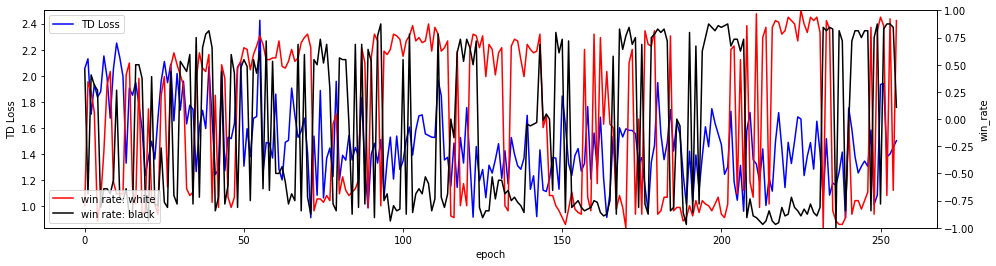

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16,4))
ax.set_xlabel("epoch")
ax.set_ylabel("TD Loss")
ax.plot(loss_data, "b-", label="TD Loss")

ax1 = ax.twinx()
ax1.plot(win_data[0], "r-", label="win rate: white")
ax1.plot(win_data[1], "k-", label="win rate: black")
ax1.set_ylabel("win_rate")
ax1.set_ylim(-1.0, 1.0)

ax.legend(loc="upper left")
ax1.legend(loc="lower left")
plt.show()

#view heatmap

In [1]:
#np.set_printoptions(precision=4, floatmode='maxprec_equal') #for print pred
othello = OthelloPlay(PolicyNet(policy_model), PolicyNet(opponent_model))
#show pred in each battle
result = ("lose", "draw", "win")
for play in (1, 2):
    reward, _ = othello.play_with_show(play)
    print(f"player: {color[play-1]} {result[int(reward)+1]}")

battle_result, _ = othello.test_battle(10)
print(f"[lose, draw, win] white: {battle_result[0]} black: {battle_result[1]}")

NameError: ignored